# Examples of Working with COGs

## Setup

For demonstrating some COG concepts, we will download a regular GeoTIFF, create a Cloud-Optimized GeoTIFF and explore how they are different.

First we use the [earthaccess](https://github.com/nsidc/earthaccess) library to setup credentials to fetch data from NASA's EarthData catalog.

In [1]:
import earthaccess
import rasterio
from rasterio.plot import show
from rio_cogeo import cog_validate, cog_info

In [2]:
earthaccess.login()

EARTHDATA_USERNAME and EARTHDATA_PASSWORD are not set in the current environment, try setting them or use a different strategy (netrc, interactive)


Enter your Earthdata Login username:  leo@developmentseed.org
Enter your Earthdata password:  ········


You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/21/2023


## Download a GeoTIFF from EarthData

Note: The whole point of  is that we _don't_ download data. So in future examples, we will demonstrate how to access just subsets of data using COG and compare that with a GeoTIFF.

In [3]:
# Download data
short_name = 'VCF5KYR'
version = '001'

veg_item_results = earthaccess.search_data(
    short_name=short_name,
    version=version,
    count=1
)

Granules found: 33


In [4]:
test_data_dir = "./test_data"
veg_files = earthaccess.download(veg_item_results, test_data_dir)
veg_gtiff_filename = f"{test_data_dir}/{veg_files[0]}"

 Getting 1 granules, approx download size: 0.07 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

File VCF5KYR_1982001_001_2018224204211.tif already downloaded


PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

## Is it a valid COG?

We can use `rio_cogeo.cog_validate` to check. It returns `is_valid`, `errors` and `warnings`.

In [5]:
cog_validate(veg_gtiff_filename)

The following warnings were found:
- The file is greater than 512xH or 512xW, it is recommended to include internal overviews

The following errors were found:
- The file is greater than 512xH or 512xW, but is not tiled


(False,
 ['The file is greater than 512xH or 512xW, but is not tiled'],
 ['The file is greater than 512xH or 512xW, it is recommended to include internal overviews'])

Return values:
    
1. `is_valid` is `False`: this is not a valid COG.
2. `errors` are `'The file is greater than 512xH or 512xW, but is not tiled'`. To be a valid COG, the file should be tiled since it has a height and width both greater than 512.
3. `warnings` are `'The file is greater than 512xH or 512xW, it is recommended to include internal overviews'`. It is recommended to provide overviews.

## Converting a GeoTIFF to COG

We can use `rio_cogeo.cog_create` to convert a GeoTIFF into a Cloud Optimized GeoTIFF

In [6]:
veg_cog_filename = veg_gtiff_filename.replace(".tif", "_cog.tif")

!rio cogeo create {veg_gtiff_filename} {veg_cog_filename}

Reading input: /Users/leo/development-seed/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/test_data/VCF5KYR_1982001_001_2018224204211.tif
  [####################################]  100%          
Adding overviews...
Updating dataset tags...
Writing output to: /Users/leo/development-seed/cloud-optimized-geospatial-formats-guide/cloud-optimized-geotiffs/test_data/VCF5KYR_1982001_001_2018224204211_cog.tif


In [7]:
cog_validate(veg_cog_filename)

(True, [], [])

This is a valid COG, so we will use it to compare with our GeoTIFF.

## Dimensions

This attribute is also sometimes called **chunks** or **internal tiles**.

Dimensions are the number of bands, rows and columns stored in a GeoTIFF. There is a tradeoff between storing lots of data in one GeoTIFF and storing less data in many GeoTIFFs. The larger a single file, the larger the GeoTIFF header and the multiple requests may be required just to read the spatial index before data retrieval. The opposite problem occurs if you make too many small files, then it takes many reads to retrieve data, and when rendering a combined visualization can greatly impact load time.

If you plan to pan and zoom a large amount of data through a tiling service in a web browser, there is a tradeoff between 1 large file, or many smaller files. The current recommendation is to meet somewhere in the middle, a moderate amount of medium files.

### Internal Blocks

Internal blocks are required if the dimensions of data are over 512x512. However you can control the size of the internal blocks. 256x256 or 512x512 are recommended. When displaying data at full resolution, or doing partial reading of data this size will impact the number of reads required. A size of 256 will take less time to read, and read less data outside the desired bounding box, however for reading large parts of a file, it may take more total read requests. Some clients will aggregate neighboring block reads to reduce the total number of requests. 

Let's check out the dimensions and blocks of our GeoTIFF and Cloud-Optimized GeoTIFF.

In [8]:
veg_gtiff_rio = rasterio.open(veg_gtiff_filename)
veg_cog_rio = rasterio.open(veg_cog_filename)

In [9]:
print(veg_gtiff_rio.shape)
veg_cog_rio.shape

(3600, 7200)


(3600, 7200)

They have the same dimensions which is what we expect, so that is good!

We can also print information about the GeoTIFF's IFD (Internal File Directory). Only one item is returned because the GeoTIFF doesn't have overviews. When we print the IFD info for the COG, which has overviews, we see more items returned.

In [10]:
cog_info(veg_gtiff_filename).IFD

[IFD(Level=0, Width=7200, Height=3600, Blocksize=(1, 7200), Decimation=0)]

In [11]:
cog_info(veg_cog_filename).IFD

[IFD(Level=0, Width=7200, Height=3600, Blocksize=(512, 512), Decimation=0),
 IFD(Level=1, Width=3600, Height=1800, Blocksize=(128, 128), Decimation=2),
 IFD(Level=2, Width=1800, Height=900, Blocksize=(128, 128), Decimation=4),
 IFD(Level=3, Width=900, Height=450, Blocksize=(128, 128), Decimation=8)]

Note for IFD Level 0, the regular GeoTIFF has a blocksize of `(1, 7200)` which implies each row of data is a separate block. So whenever reading in data, even if only a few columns are required, the full row must be read.

## Overviews

Overviews are downsampled (aggregated) data intended for visualization.
The best resampling algorithm depends on the range, type, and distribution of the data.

The smallest size overview should match the tiling components’ fetch size, typically 256x256. Due to aspect ratio variation just aim to have at least one dimension at or slightly less than 256. The COG driver in GDAL, or rio cogeo tools should do this.

There are many resampling algorithms for generating overviews. When creating overviews several options should be compared before deciding which resampling method to apply.

GDAL >= 3.2 allows for the overview resampling method to be set directly.

TODO: need to add hints on how to check which resampling method to use for overviews. Possibly provide code for comparing.

In [12]:
veg_gtiff_rio.overviews(1)

[]

In [13]:
veg_cog_rio.overviews(1)

[2, 4, 8]

By displaying each overview, we can see how the dimensions get coarser for each overview level.

out height: 1800
out width: 3600


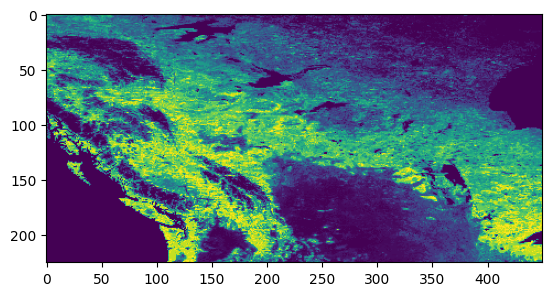

out height: 900
out width: 1800


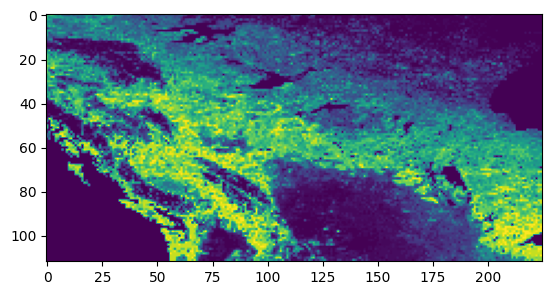

out height: 450
out width: 900


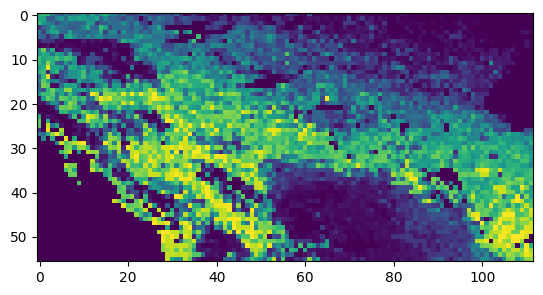

In [14]:
def show_overviews(geotiff):  
    for overview in geotiff.overviews(1):
        out_height = int(geotiff.height // overview)
        out_width = int(geotiff.width // overview)
        print(f"out height: {out_height}")
        print(f"out width: {out_width}")    
        # read first band of file and set shape of new output array
        window_size_height = round(out_height/8)
        window_size_width = round(out_width/8)
        image = veg_cog_rio.read(1, out_shape=(1, out_height, out_width))[
            window_size_height:(window_size_height*2),
            window_size_width:(window_size_width*2),
        ]
        show(image)
        
show_overviews(veg_cog_rio)

We can generate more and different overviews, through different tilesizes and resampling.

In [15]:
import gen_overviews

In [16]:
tmp_dst = gen_overviews.create_overviews_from_gtiff(veg_gtiff_rio)
tmp_cog = rasterio.open(tmp_dst)
cog_info(tmp_dst).IFD

[IFD(Level=0, Width=7200, Height=3600, Blocksize=(1, 7200), Decimation=0),
 IFD(Level=1, Width=3600, Height=1800, Blocksize=(128, 128), Decimation=2),
 IFD(Level=2, Width=1800, Height=900, Blocksize=(128, 128), Decimation=4),
 IFD(Level=3, Width=900, Height=450, Blocksize=(128, 128), Decimation=8),
 IFD(Level=4, Width=450, Height=225, Blocksize=(128, 128), Decimation=16)]

Note: Now we have overviews but there are still no tiles on the Level 0 IFD.

In [17]:
overviews = tmp_cog.overviews(1)
overviews

[2, 4, 8, 16]

out height: 1800
out width: 3600


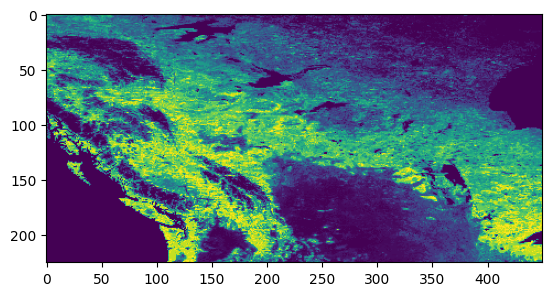

out height: 900
out width: 1800


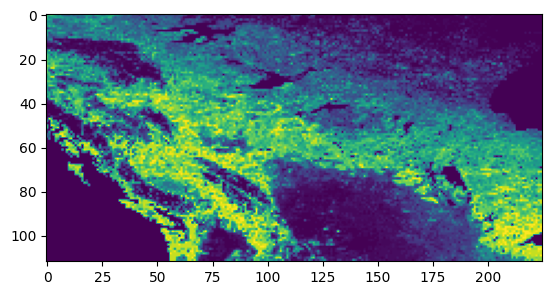

out height: 450
out width: 900


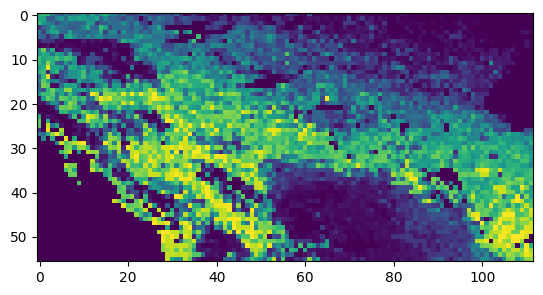

out height: 225
out width: 450


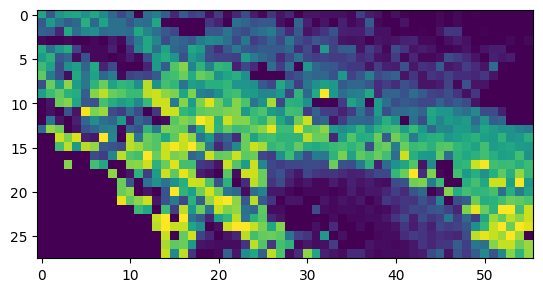

In [18]:
show_overviews(tmp_cog)

# Data Type

The smallest possible data type, that still represents the data appropriately, should be used. It is not generally recommended to shift data from float to integer by multiplying, a space saving technique, as end users then need to undo this step to use the data. Data compression is preferred, see also Compression.

Scenario: If the COG is intended only for visualization, conversion to 3 band byte will improve performance. 

# Compression (aka File Size)

The biggest benefit to compression is on the storage side. It’s always recommended to use a lossless compression method. Deflate or LZW are the most recommended compression algorithms, there are some choices that depend on the data type and distribution, and if the goal is maximum compression or not. Maximum compression does result in some performance loss.

# No Data
Setting a no data value makes it clear to users and visualization tools what pixels are not actually data. For visualization this allows these pixels to be easily hidden (transparent). Historically many values have been used, 0, -9999, etc… The key is to make sure the GDAL flag for no data is set. It is also suggested that the smallest negative value be used instead of a random value. For byte and unsigned integers/floats this will be 0, if 0 has meaning in your data use a different value (like the max possible value). Having the right nodata flag set is important for overview generation.

# Projection

Read performance can be greatly impacted by the choice of projection and the particular applications used for dynamic tile serving. Using a known CRS defined in the PROJ database (typically EPSG code) is preferred over custom projections. Load times can be 5-20 times greater when using a custom projection. Whenever applying projections make sure to use WKT2 representation. If using a database of known projections this should be fine, there are known issues around manually setting proj-strings.


## What we don’t know (areas of research)

* The optimum size of data at which splitting across files improves performance as a multi-file dataset instead of a single file.
* When to recommend particular internal tile sizes
* Compression impacts on http transfer rates.
* Support for COG creation in other common scientific platforms (e.g. R)


## Additional Resources

* [An Introduction to Cloud Optimized GeoTIFFS (COGs) Part 1: Overview](https://developers.planet.com/docs/planetschool/an-introduction-to-cloud-optimized-geotiffs-cogs-part-1-overview/)
* [Do you really want people using your data?](https://medium.com/@_VincentS_/do-you-really-want-people-using-your-data-ec94cd94dc3f)